# CA5

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV

In [22]:
from sklearn.svm import SVR
from sklearn.decomposition import PCA

### Reading data

In [16]:
df = pd.read_csv('assets/train.csv')

### Data exploration and visualisation

       Length (cm)  Width (cm)  Weight (g)  Pericarp Thickness (mm)  \
count   999.000000  999.000000  999.000000               998.000000   
mean     15.574675    6.641572  169.346406                 4.619499   
std       6.267303    2.139023  123.779026                 2.829503   
min       0.300000    0.100000    0.560000                 0.000000   
25%      11.290000    5.140000   79.020000                 2.400000   
50%      15.520000    6.600000  147.230000                 4.280000   
75%      19.900000    8.045000  227.625000                 6.560000   
max      35.570000   13.620000  869.970000                14.630000   

       Seed Count  Capsaicin Content  Vitamin C Content (mg)  Sugar Content  \
count  999.000000         999.000000             1000.000000     999.000000   
mean   128.731301           4.215385              142.035180       3.283534   
std     87.270366           3.163125               72.246142       1.938264   
min      0.040000           0.010000        

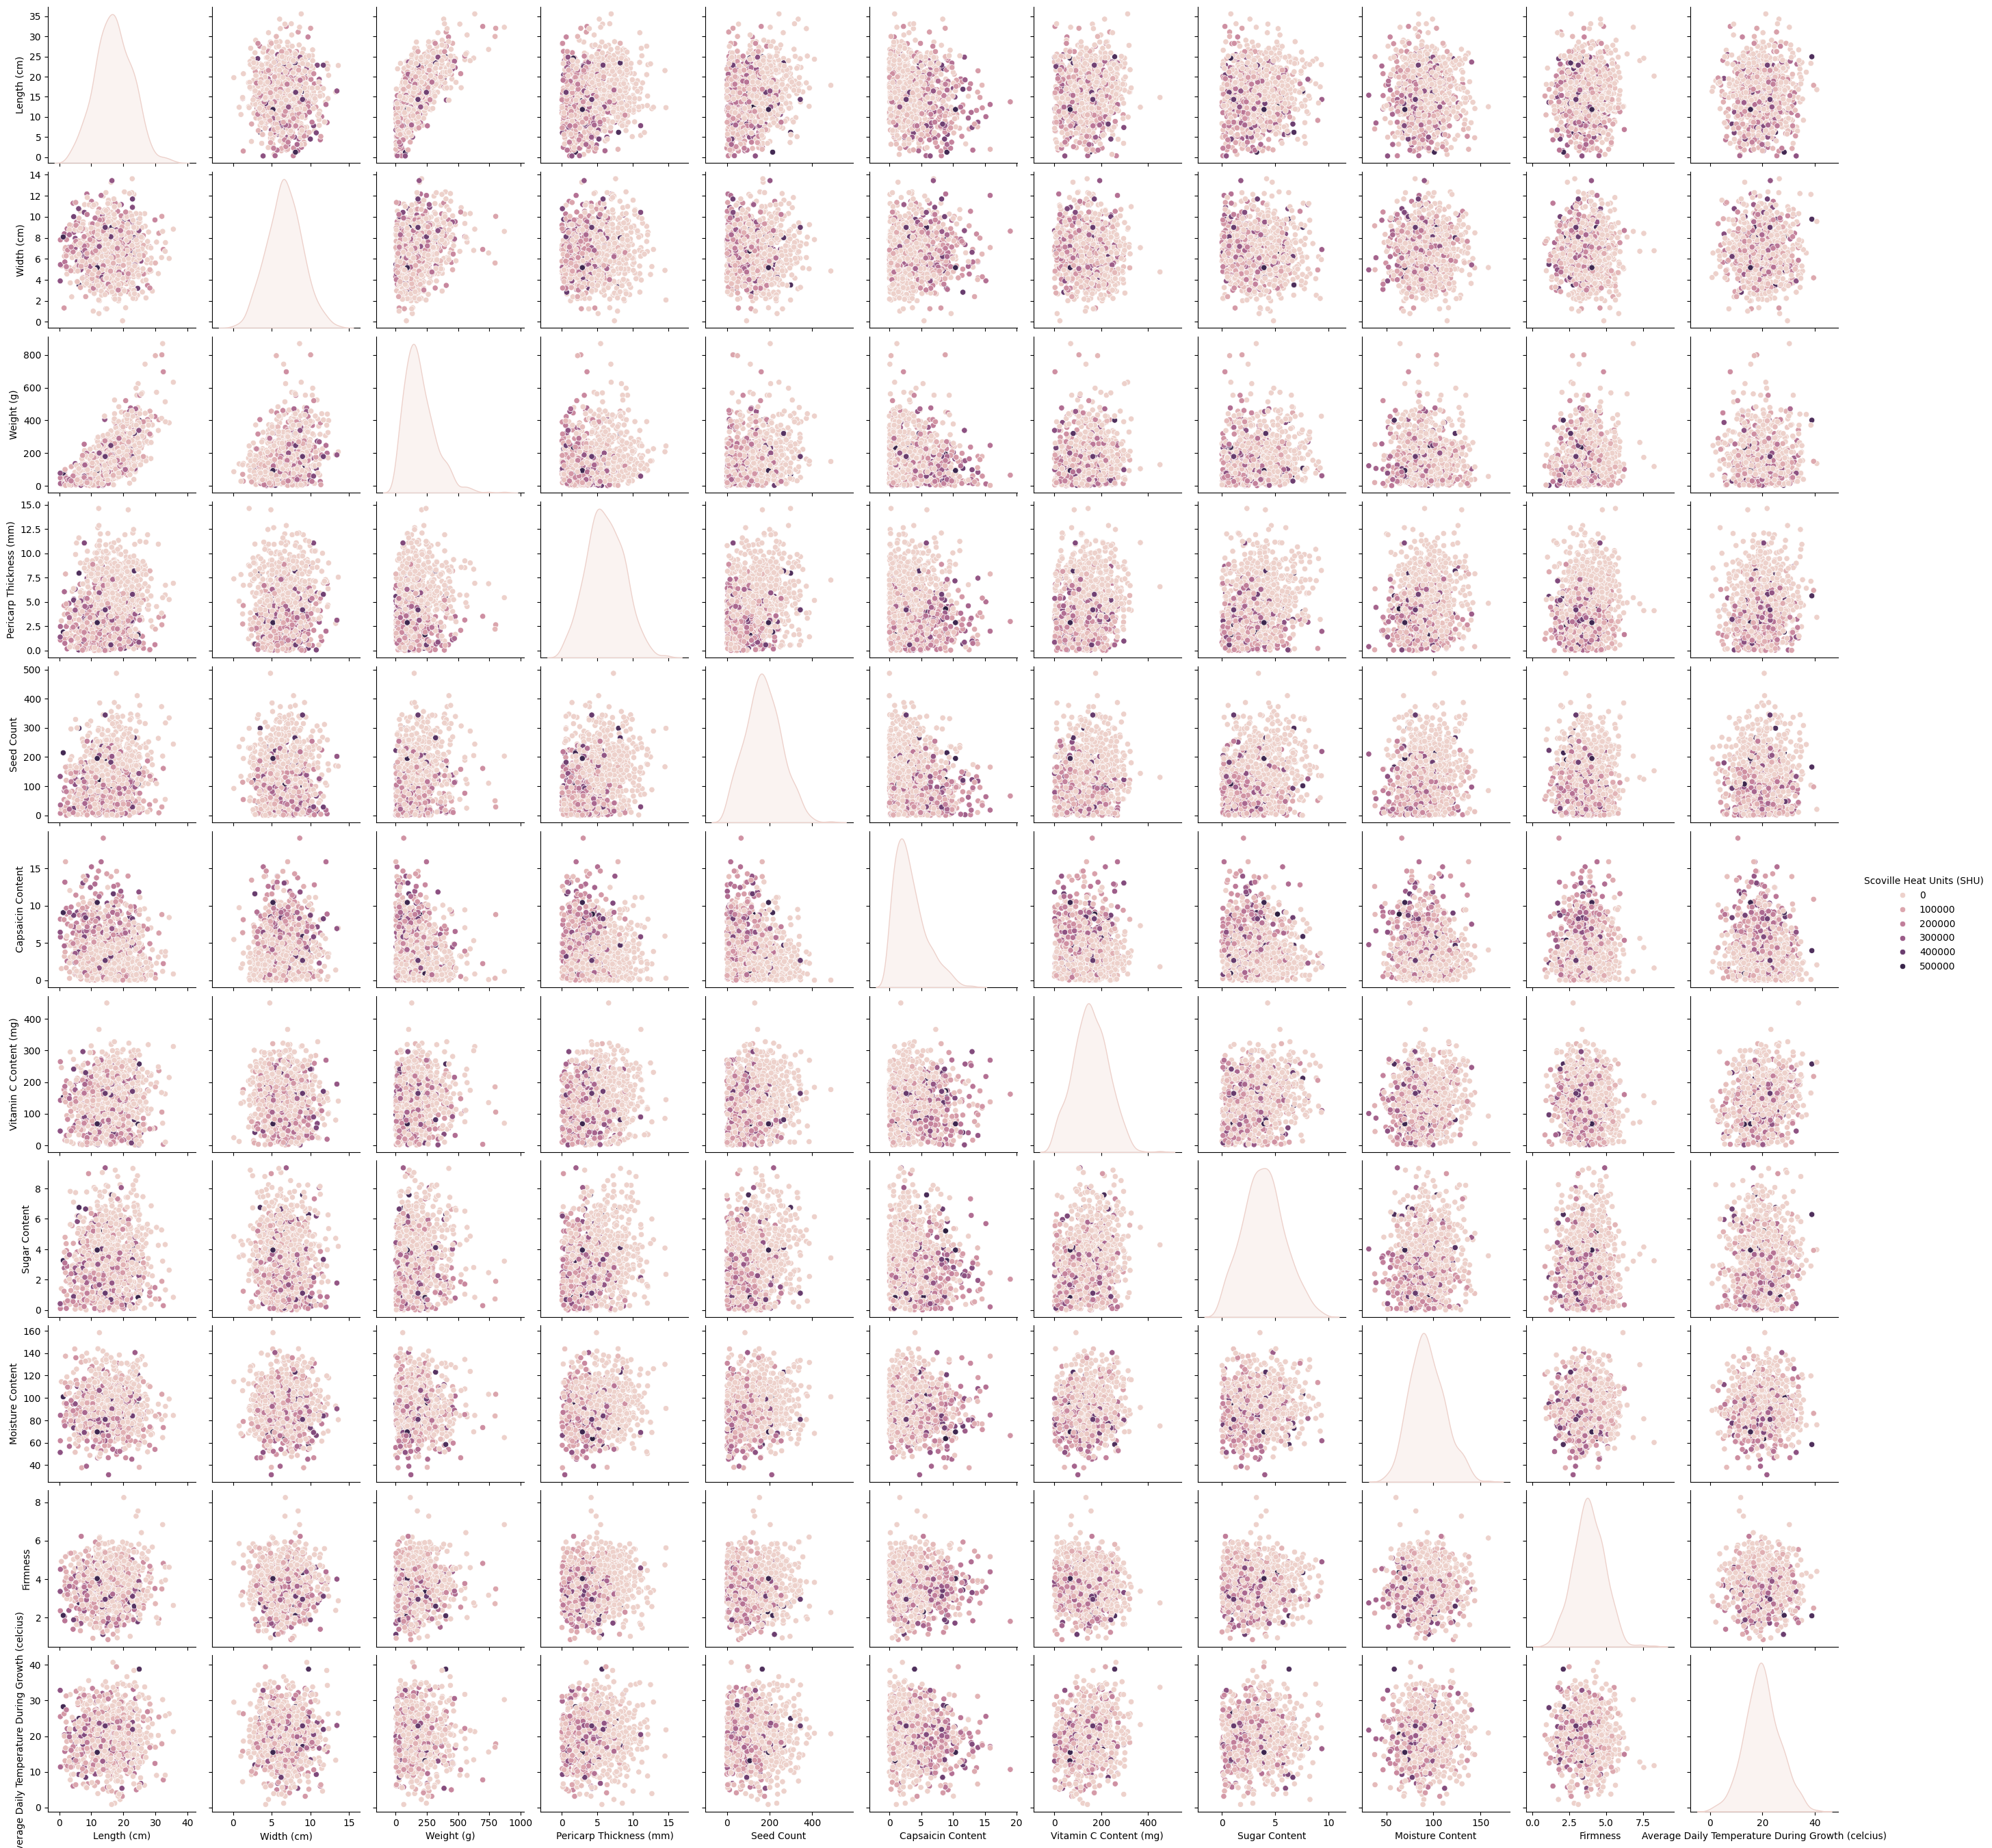

In [4]:
print(df.describe())

# check for missing values
print(df.isnull().sum())

sns.pairplot(df, hue='Scoville Heat Units (SHU)')
plt.show()

### Turn categorical variables into numerical 

In [17]:
numeric_columns = np.array(df.select_dtypes(include=['float64', 'int64']).columns)

category_columns = np.array(df.select_dtypes(include=['object']).columns)

print(numeric_columns)
print(category_columns)

['Length (cm)' 'Width (cm)' 'Weight (g)' 'Pericarp Thickness (mm)'
 'Seed Count' 'Capsaicin Content' 'Vitamin C Content (mg)' 'Sugar Content'
 'Moisture Content' 'Firmness'
 'Average Daily Temperature During Growth (celcius)'
 'Scoville Heat Units (SHU)']
['color' 'Harvest Time' 'Average Temperature During Storage (celcius)']


### Data cleaning

In [18]:
# Remove column 'Average Temperature During Storage (celcius)' because it has a lot of missing values
df = df.drop(columns=['Average Temperature During Storage (celcius)'])
category_columns = np.delete(category_columns, np.where(category_columns == 'Average Temperature During Storage (celcius)'))

print(category_columns)

['color' 'Harvest Time']


#### Remove missing values and outliers



### Data preprocessing and visualisation

#### Split data

In [19]:
y = df['Scoville Heat Units (SHU)']
X = df.drop(columns=['Scoville Heat Units (SHU)'])
numeric_columns = np.delete(numeric_columns, np.where(numeric_columns == 'Scoville Heat Units (SHU)'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelling

In [20]:
# Create a transformer for the numeric columns
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # fill missing values with the mean of the column
    ('scaler', StandardScaler())
])

# Create a transformer for the category columns
category_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # fill missing values with the most frequent value of the column
    ('onehot', OneHotEncoder())
])

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', category_transformer, category_columns)
    ]
)

In [11]:
# Test with PLS

pls = Pipeline([
    ('preprocessor', preprocessor),
    ('pls', PLSRegression())
])

param_grid = {
    'pls__n_components': [1, 2, 3, 4, 5, 6 ,7],
    'pls__scale': [True, False],
    'pls__max_iter': [100, 200, 300, 400, 500, 1000],
}

pls_grid_search = GridSearchCV(estimator = pls, 
                               param_grid = param_grid,
                               cv = 10, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1,
                               verbose = 1)


In [12]:
pls_model = pls_grid_search.fit(X_train, y_train)

print(pls_model.best_score_)
print(pls_model.best_params_)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


-69637.21618669253
{'pls__max_iter': 100, 'pls__n_components': 2, 'pls__scale': False}


In [24]:
# Sett up pipleine
pipeline_svc = Pipeline([('preprocessor', preprocessor), 
                        ('svc', SVR(max_iter=100000))]) # Model we train with max_iterations so it dont take to long. # Model using kernal

C_range     = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # For regularization parameter C.
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]         # For scaling parameter gamma in rbf-kernel.
#random_state = [1, 10, 50, 100, 200, 500, 700, 1000]               # For random state.
kernal_range = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'] # For kernel type.

# Create a paramgrid with all differnet varibles to combine
param_grid = [{'svc__C': C_range, 'svc__kernel': kernal_range, 'svc__gamma': gamma_range, 'svc__random_state': [1]}] 

# Set up the grid search
gs_svc = GridSearchCV(estimator=pipeline_svc, # Use the pipeline we created
                  param_grid=param_grid,  # Use the different params we created
                  scoring='neg_mean_absolute_error',  # Sett F1 macro as score
                  cv=10, # Number of cross validaions
                  n_jobs=-1, # Use all avalible cores
                  verbose=1) # Print total number of combinations to itterate thru.

# Fit the model
gs_svc_res = gs_svc.fit(X_train, y_train) 

# Print results as best params and its corresponding score
print(gs_svc_res.best_score_)
print(gs_svc_res.best_params_)

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


In [33]:
# Create a binary target variable for the classification model
y_binary = (y > 0).astype(int)

# Split the data into training and testing sets
X_train_clf, X_test_clf, y_binary_train, y_binary_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)
X_train_reg, X_test_reg, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


pipeline_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# Train the classification model with grid search
param_grid = {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__max_depth': [10, 20, 40, 50],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2, 4]
}

grid_search_clf = GridSearchCV(estimator = pipeline_clf,
                                 param_grid = param_grid,
                                 cv = 5,
                                 scoring = 'neg_mean_absolute_error',
                                 n_jobs = -1,
                                 verbose = 1)


grid_search_clf.fit(X_train_clf, y_binary_train)

# Predict on the test data using the trained classification model
y_binary_pred = grid_search_clf.best_estimator_.predict(X_test)

# For those samples that are predicted as spicy peppers, train a regression model
X_train_spicy = X_train[y_binary_train == 1]
y_train_spicy = y_train[y_binary_train == 1]

pipeline_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(random_state=42))
])

param_grid = {
    'reg__n_estimators': [100, 200, 300, 400],
    'reg__max_depth': [10, 20, 40, 50],
    'reg__min_samples_split': [2, 5],
    'reg__min_samples_leaf': [1, 2, 4]
}

grid_search_reg = GridSearchCV(estimator = pipeline_reg,
                                    param_grid = param_grid,
                                    cv = 5,
                                    scoring = 'neg_mean_absolute_error',
                                    n_jobs = -1,
                                    verbose = 1)


grid_search_reg.fit(X_train_reg, y_train)

# Predict the SHU of the spicy peppers using the trained regression model
X_test_spicy = X_test[y_binary_pred == 1]
y_pred_spicy = grid_search_reg.best_estimator_.predict(X_test_spicy)

# Combine the results of the classification and regression models into a single prediction vector
y_pred = y_binary_pred.copy()
y_pred[y_binary_pred == 1] = y_pred_spicy

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_66749/510002674.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_spicy = X_train[y_binary_train == 1]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
# Load the new dataset
test_data = pd.read_csv('assets/test.csv')

# Preprocess the test data in the same way as the training data
X_new = test_data.drop(columns=['Average Temperature During Storage (celcius)'])

# Predict whether the peppers are spicy using the trained classification model
y_binary_new = grid_search_clf.best_estimator_.predict(X_new)

# For those samples that are predicted as spicy peppers, predict the SHU using the trained regression model
X_new_spicy = X_new[y_binary_new == 1]
y_new_spicy = grid_search_reg.best_estimator_.predict(X_new_spicy)

# Combine the results of the classification and regression models into a single prediction vector
y_new = y_binary_new.copy()
y_new[y_binary_new == 1] = y_new_spicy

# Save the predictions to a CSV file
output = pd.DataFrame({'Scoville Heat Units (SHU)': y_new})
output.to_csv('assets/predictions.csv', index=True)

### Final evaluation

In [18]:
df = pd.read_csv('assets/train.csv')

# Remove column 'Average Temperature During Storage (celcius)' because it has a lot of missing values
df = df.drop(columns=['Average Temperature During Storage (celcius)'])

y = df['Scoville Heat Units (SHU)']
X = df.drop(columns=['Scoville Heat Units (SHU)'])

pls_model.best_estimator_.fit(X, y)
print(pls_model.score(X, y))

-67292.94905932066


### Kaggle submission

In [21]:
df = pd.read_csv('assets/test.csv')

# Remove column 'Average Temperature During Storage (celcius)' because it has a lot of missing values
df = df.drop(columns=['Average Temperature During Storage (celcius)'])

y = pls_model.best_estimator_.predict(df)

#only save index and y value
df = pd.DataFrame(y, columns=['Scoville Heat Units (SHU)'])
df.to_csv('assets/results.csv', index=True)